# **Elasticity equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Elasticity equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [9]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [10]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Elasticity equations take the form

$-\nabla \cdot \sigma = f$

together with suitable boundary conditions.

To derive the weak form of the equations, multiply the equation by $v\in V$, and then integrate over the domain $\Omega$ and use Green's formula
$
(-\nabla \cdot \sigma ,v) = (\nabla \sigma , \nabla v)
- <\sigma \cdot n, v>_{\Gamma}
$

To model

We seek a finite element approximation $u\in V$ such that

$(\nabla \sigma,\nabla v) - <\sigma \cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $v \in V$.



# **Method**

**Define domain and mesh**

In [11]:
def setup():
  # Define rectangular domain
  L = 4.0
  H = 2.0

  # Define subdomains (for boundary conditions)
  class Left(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], 0.0)

  class Right(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[0], L)

  class Lower(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], 0.0)

  class Upper(SubDomain):
      def inside(self, x, on_boundary):
          return near(x[1], H)

  left = Left()
  right = Right()
  lower = Lower()
  upper = Upper()

  # Generate mesh (examples with and without a hole in the mesh)
  resolution = 32
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(1.5,0.25*H),0.2) - Circle(Point(0.5,0.5*H),0.2) - Circle(Point(2.0,0.75*H),0.2), resolution)

  # Local mesh refinement (specified by a cell marker)
  no_levels = 0
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(1.5, 0.5)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)

 # plt.figure()
# plot(mesh)
 # plt.show()

  return mesh, L, H

**Define finite element approximation spaces and boundary conditions**

In [12]:
def boundaries(mesh, L, H, bcuCon):
  # Generate finite element space
  VE = VectorElement("CG", mesh.ufl_cell(), 1)

  V = FunctionSpace(mesh, VE)

  # Define trial and test functions
  u = TrialFunction(V)
  v = TestFunction(V)

  d = Function(V)


  # Define boundary conditions
  class DirichletBoundaryLower(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], 0.0)

  class DirichletBoundaryUpper(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[1], H)

  class DirichletBoundaryLeft(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], 0.0)

  class DirichletBoundaryRight(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and near(x[0], L)

  class DirichletBoundaryObjects(SubDomain):
      def inside(self, x, on_boundary):
          return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  bcu_left0 = DirichletBC(V.sub(0), 0.0, dbc_left)
  bcu_left1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_right0 = DirichletBC(V.sub(0), 0.0, dbc_right)
  bcu_right1 = DirichletBC(V.sub(1), 0.0, dbc_right)
  bcu_upper0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upper1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_lower0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_lower1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), bcuCon[0], dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), bcuCon[1], dbc_objects)

  #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  bcu = [bcu_left0, bcu_left1, bcu_right0, bcu_right1, bcu_upper0, bcu_upper1, bcu_lower0, bcu_lower1, bcu_obj0, bcu_obj1]

  return u, v, d, V, bcu

# **Results**

**Define and solve variational problem**

In [13]:
def solver(u, v, d, V, bcu, E, nu):
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  dim = u.geometric_dimension()
  mu = E*0.5/(1+nu)
  lambda_ = nu*E/((1.0+nu)*(1.0-2.0*nu))

  def epsilon(u):
      return 0.5*(grad(u) + grad(u).T)

  def sigma(u):
      #return 2.0*mu*epsilon(u)
      return lambda_*div(u)*Identity(dim) + 2.0*mu*epsilon(u)

  # Define variational problem on residual form: r(u,v) = 0
  residual = ( inner(sigma(u), epsilon(v))*dx - inner(f, v)*dx )

  au = lhs(residual)
  Lu = rhs(residual)

  A = assemble(au)
  b = assemble(Lu)

  [bc.apply(A, b) for bc in bcu]
  [bc.apply(d.vector()) for bc in bcu]

  solve(A, d.vector(), b, "bicgstab", "default")

  return d

# **How does the response change with Young's modulus and Poission's ratio**

From Benny Lautrups's "Linear Elasticity", we know that with a larger Young's modulus E, the material becomes harder to stretch. A higher Poisson's ratio increases the expansion in the lateral direction. To investigate how the response changes when modifying these numbers, we can look at different combinations of values for these two. Poisson's ratio $\nu$ is between $0 \leq \nu < 0.5$.

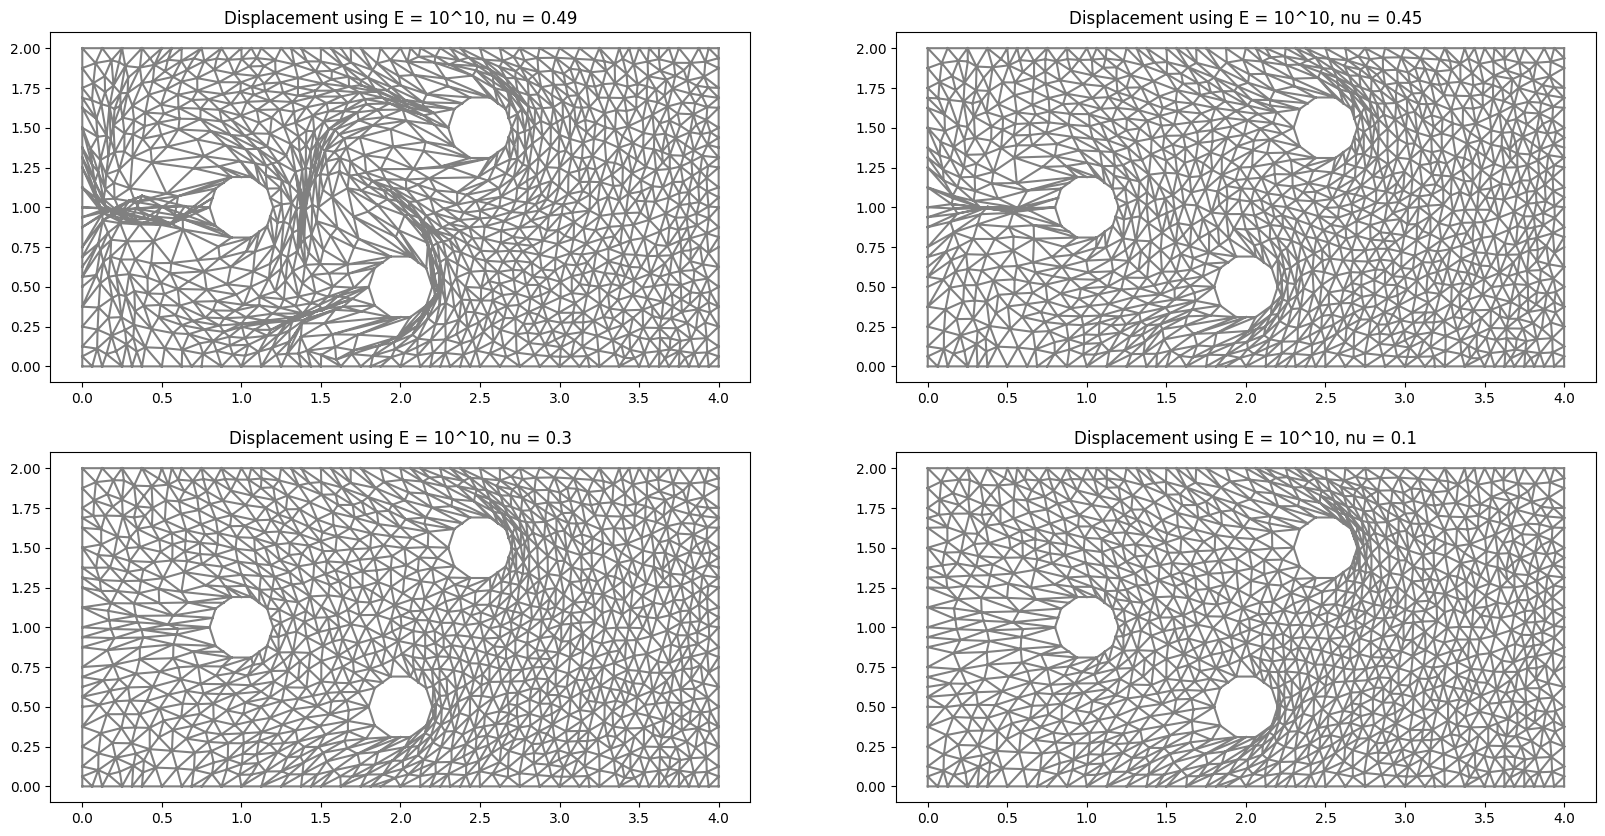

In [14]:
#### looking at different nus
nus = [0.49, 0.45, 0.3, 0.1]
bcuCon = [0.5, 0]

plt.figure(figsize=(20, 10))
for i in range(4):
  E = 1.0e10
  nu = nus[i]

  mesh, L, H = setup()
  u, v, d, V, bcu = boundaries(mesh, L, H, bcuCon)
  d = solver(u, v, d, V, bcu, E, nu)

  ## plotting
  ALE.move(mesh, d)
  plt.subplot(2,2,i+1)
  plot(mesh, title=f"Displacement using E = 10^10, nu = {nus[i]}")


plt.show()



In the above plots, we use different $\nu$ but same $E$. We can see that a higher Poisson's ratio ($\nu$) results in a more deformed mesh and more elasticity of the cells. The choice of Young's modulus (E) do not seem to impact the elasticity of the cells. The difference is the biggest for the highest $\nu$ compared to the other plots, and we have a lot less elasticity for $\nu \leq 0.45$. $\nu = 0.3$, $\nu = 0.10$ show a very similar result.

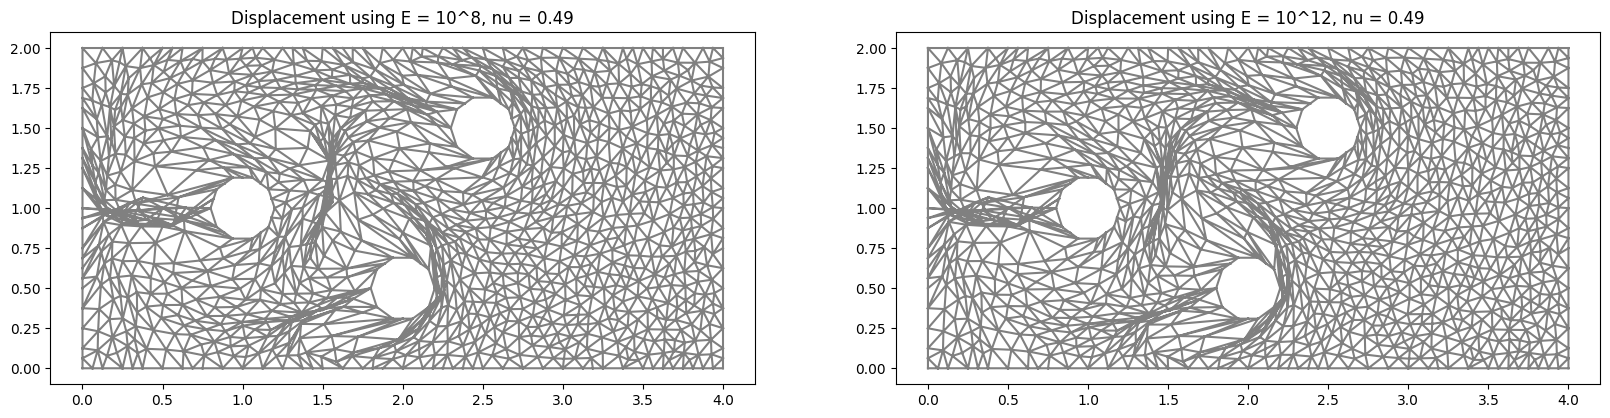

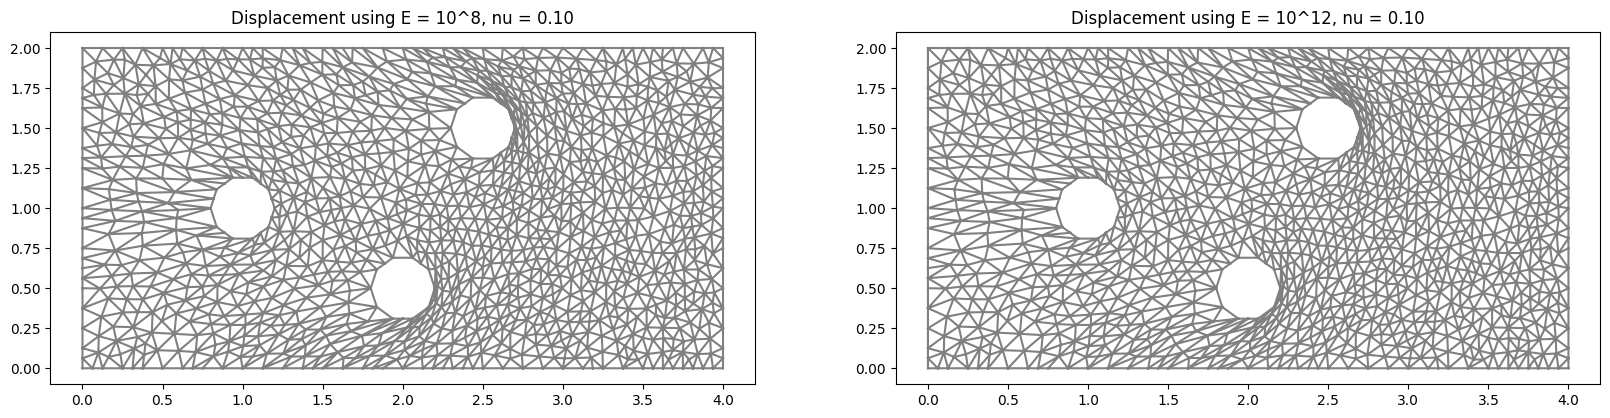

In [15]:
### looking at different Es, high and low nu

Es = [1.0e8, 1.0e12]
nu = 0.49
plot_var = [8, 12]
bcuCon = [0.5, 0]

plt.figure(figsize=(20, 10))
for i in range(2):
  E = Es[i]

  mesh, L, H = setup()
  u, v, d, V, bcu = boundaries(mesh, L, H, bcuCon)
  d = solver(u, v, d, V, bcu, E, nu)

  ALE.move(mesh, d)

  plt.subplot(1,2,i+1)
  plot(mesh, title=f"Displacement using E = 10^{plot_var[i]}, nu = 0.49")


plt.show()

## low nu
nu = 0.1

plt.figure(figsize=(20, 10))
for i in range(2):
  E = Es[i]

  mesh, L, H = setup()
  u, v, d, V, bcu = boundaries(mesh, L, H, bcuCon)
  d = solver(u, v, d, V, bcu, E, nu)

  ALE.move(mesh, d)

  plt.subplot(1,2,i+1)
  plot(mesh, title=f"Displacement using E = 10^{plot_var[i]}, nu = 0.10")


plt.show()

In these plots we can see two different $\nu$ used for two different $E$, one high and one low. The elasticity of the cells/deformation of the mesh is unchanged between the two different values of $E$ compared, but very different in the choice of $\nu$, similar to the prior results.

# **Change of movement in cylinder**
In the original configuration, we move 0.5 in x-direction and 0 in y-direction. Here, we try some different values for x and y to see how it changes the deformation of the material, using the original setup with $E = 10^{10}, \nu=0.3$

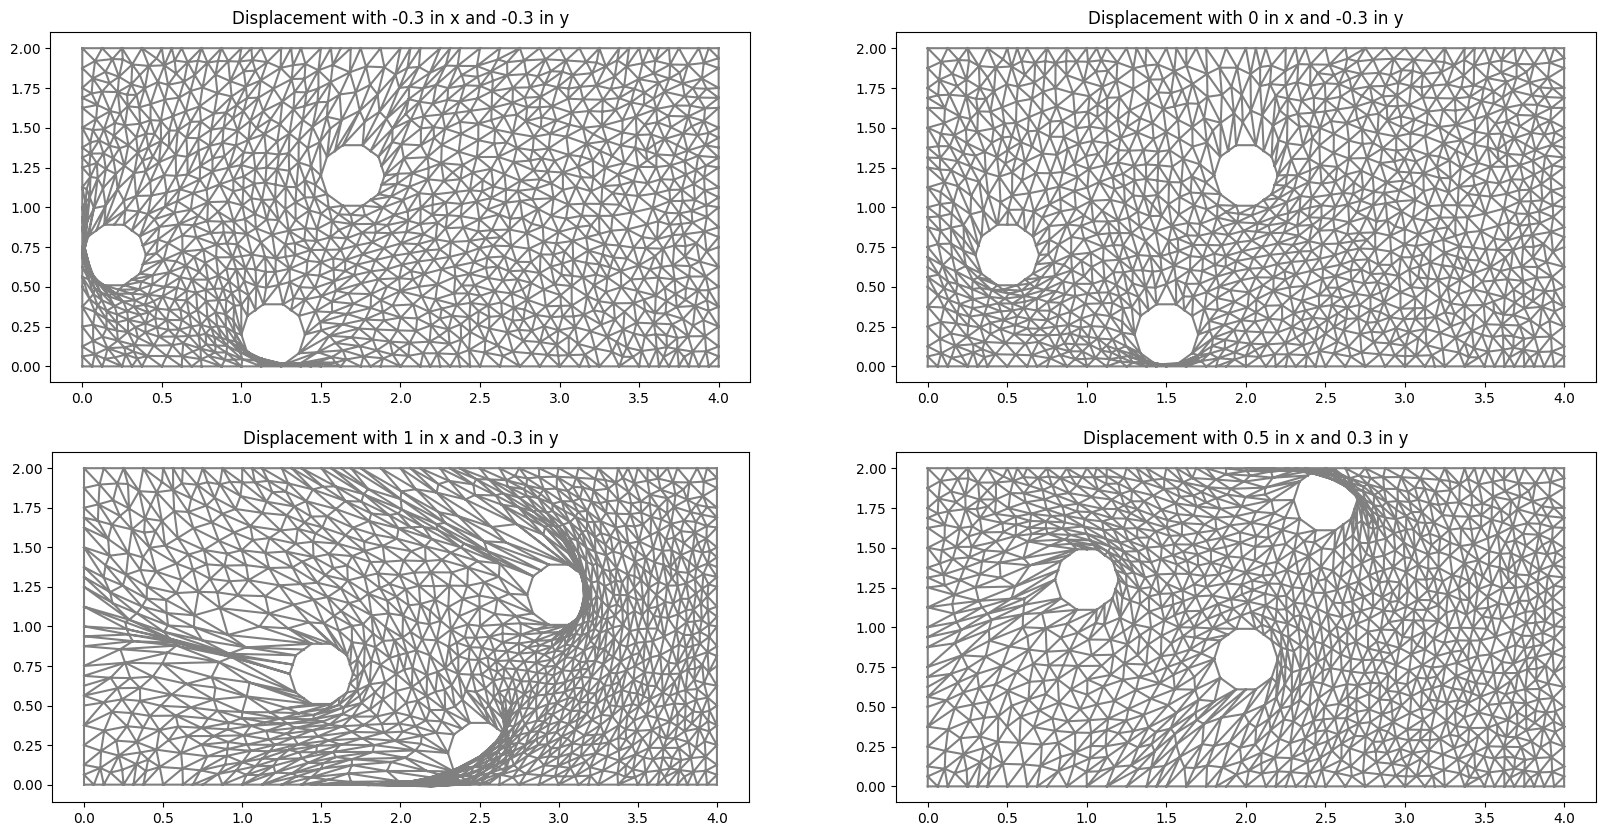

In [16]:
#### looking at different movements
bcuCons = [[-0.3, -0.3], [0, -0.3], [1, -0.3], [0.5, 0.3]]

E = 1.0e10
nu = 0.3

plt.figure(figsize=(20, 10))
for i in range(4):
  bcuCon = bcuCons[i]

  mesh, L, H = setup()
  u, v, d, V, bcu = boundaries(mesh, L, H, bcuCon)
  d = solver(u, v, d, V, bcu, E, nu)

  ## plotting
  ALE.move(mesh, d)
  plt.subplot(2,2,i+1)
  plot(mesh, title=f"Displacement with {bcuCon[0]} in x and {bcuCon[1]} in y")


plt.show()

The cells get longer behind the cylinder and squished in front of them. In the first, thrird and fourth plot the cylinder collides with the mesh either because they are too close to the boundary (1st, 4th) or a too large displacement in x-direction (3rd). In the second plot, the most deformation also happens at the boundary and some elongation in the cylinder at the top. A bigger movement results in more elastic cells.

# **Discussion**

A Elasticity equation was solved with a finite element method.